## L2L by GD by GD - First experiments

Target of this notebook is to reproduce some of the results from DeepMind’s paper [“Learning to learn by gradient descent by gradient descent”](https://arxiv.org/abs/1606.04474) and hopefully explore some of the doors it opens.
This paper was pointed out to me by Cyprien de Masson who works at ... you guessed it ... DeepMind.
@Cyprien : thanks for that !  
I was, at the time, scrabbling in the dark, trying to construct an optimizer with a very simple neural network structure, but using bayesian optimization to find the good parameters, instead of the good old gradient descent, because it seemed simpler as an initial approach and avoided having to deal with the memory problem of loading 100s of tensorflow graph into a single graph (corresponding to the number of iterations). Also I wasn't sure a problem with such chaotic behaviour as gradient descent could be optimized by gradient descent (i was thinking, the scope of optimization would have to be limited to 10 or 20 steps to have meaningful gradients)
I have also re-used Llion Jones's very simple, yet efficient way of implementing “Learning to learn" ideas as explained in ["Learning to Learn by Gradient Descent by Gradient Descent - As simple as possible in TensorFlow"](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2)

Let's start by importing tensorflow and a couple of usefull tools

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

If you are using the GPU version of tensorflow you can choose which PU to use. Here I'm using the CPU because I'll start with small problems where GPU don't really speed things up.

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

### Summary of Llion Jone's Notebook

Just to be clear, the code in this section is, more or less, a copy paste from [Llion Jones's article](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2).  
I encourage you to read it if you want to understand how it is set-up

In [4]:
DIMS = 2  # Dimensions of the quadratic function, the simplest application problem in DeepMind's paper

scale = tf.random_uniform([DIMS], 0.5, 1.5)
# The scale vector gives a different shape to the quadratic function at each initialization 

def quadratic(x):
  x = scale*x
  return tf.reduce_sum(tf.square(x))

In [5]:
# Some reference optimizers for benchmarking

def g_sgd(gradients, state, learning_rate=0.1):
  # Vanilla Stochastic Gradient Descent
  return -learning_rate*gradients, state

def g_rms(gradients, state, learning_rate=0.1, decay_rate=0.99):
  # RMSProp
  if state is None:
    state = tf.zeros(DIMS)
  state = decay_rate*state + (1-decay_rate)*tf.pow(gradients, 2)
  update = -learning_rate*gradients / (tf.sqrt(state)+1e-5)
  return update, state

In [6]:
TRAINING_STEPS = 20  # This is 100 in the paper

initial_pos = tf.random_uniform([DIMS], -1., 1.)

def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses

In [7]:
sgd_losses = learn(g_sgd)
rms_losses = learn(g_rms)

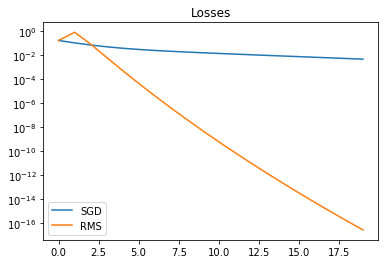

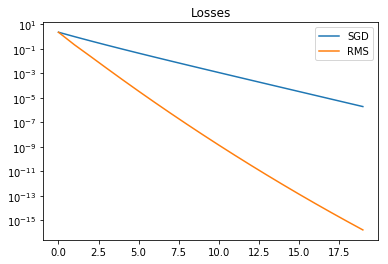

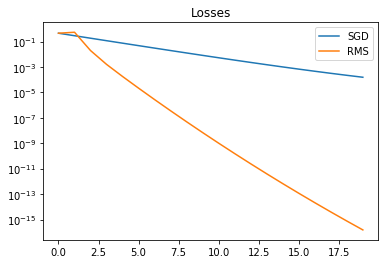

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x = np.arange(TRAINING_STEPS)
for _ in range(3): 
  sgd_l, rms_l = sess.run([sgd_losses, rms_losses])
  p1, = plt.semilogy(x, sgd_l, label='SGD')
  p2, = plt.semilogy(x, rms_l, label='RMS')
  plt.legend(handles=[p1, p2])
  plt.title('Losses')
  plt.show()        

In [9]:
# Now let's define the RNN optimizer
LAYERS = 2
STATE_SIZE = 20

cell = tf.contrib.rnn.MultiRNNCell(
  [tf.contrib.rnn.LSTMCell(STATE_SIZE) for _ in range(LAYERS)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, STATE_SIZE)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

def g_rnn(gradients, state):
  # Make a `batch' of single gradients to create a 
  # "coordinate-wise" RNN as the paper describes. 
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(gradients, state)
  # Squeeze to make it a single batch again.
  return tf.squeeze(update, axis=[1]), state

In [10]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  return optimizer.apply_gradients(zip(gradients, v))

# The "meta" optimization is first applied to minimize the sum of the 20 RNN iterations results
rnn_losses = learn(g_rnn)
sum_losses = tf.reduce_sum(rnn_losses)
apply_update = optimize(sum_losses, learning_rate=0.0003)

In [11]:
sess.run(tf.global_variables_initializer())

ave = 0
for i in range(4000):
    err, _ = sess.run([sum_losses, apply_update])
    ave += err
    if i % 1000 == 0:
        print(ave / 1000 if i!=0 else ave)
        ave = 0
print(ave / 1000)

184.156433105
2.04518832605
0.792225923559
0.835880959226
0.803534175634


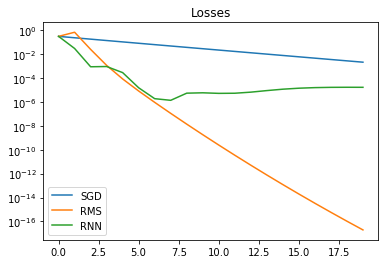

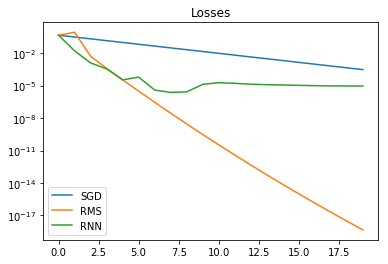

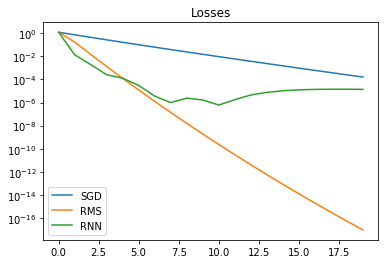

In [12]:
# Graph to compare RNN to the 2 baseline optimizers defined above
x = np.arange(TRAINING_STEPS)
for _ in range(3): 
  sgd_l, rms_l, rnn_l = sess.run(
        [sgd_losses, rms_losses, rnn_losses])
  p1, = plt.semilogy(x, sgd_l, label='SGD')
  p2, = plt.semilogy(x, rms_l, label='RMS')
  p3, = plt.semilogy(x, rnn_l, label='RNN')
  plt.legend(handles=[p1, p2, p3])
  plt.title('Losses')
  plt.show()

In summary, with this first try, we get an RNN that beats SGD but doesn't match RMSProp after 5 iterations.
Llion Jones mentions, in his article, a problem associated with the approach used above, which might explain why the loss value stops decreasing at around 1e-5 or 1e-6 : the gradients get so small that the RNN isn’t able to compute sensible updates. That's actually a key feature of neural networks : to work well, they need their inputs to remain within a specific scale. This is not the case here since we are feeding into the RNN gradients that start at around 1 but could go down to a much lower value if the optimizer works well and actually find the zero machine.  
DeepMind's paper proposes a solution to this : use the log gradient and the sign instead of the gradient. See the paper for details. We will try to implement that later in this article. We will also see that there may be other ways to deal with this problem in episode 2 of this series.

### Some helper functions and formatting
Before we try to improve our RNN performance, let's define a few functions to streamline the code

In [13]:
def print_dict(*args):
  """Prints variables in a dict format for easier reading"""
  dict_name = dict((name,eval(name)) for name in args)
  print(dict_name)

Below the same optim as before but run for 20,000 iterations and with some additional variables, printed with the function above, to track the convergence progress :

In [14]:
sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(20001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 2000 == 0 :
    sum_error = '{:.2f}'.format(sum(errors)) # Parameter being optimized
    optim_result = '{:.2E}'.format(errors[-1]) # Result of the RNN after 20 iterations
    # And below the rolling average of the log10 result of RNN
    # In other words, you get -6 if the RNN result oscillates between 1e-5 and 1e-7
    average_log_result = '{:.2f}'.format(np.log10(list_result[-2000:]).mean())
    print_dict('it', 'sum_error', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
# Naming convention will be : name of the optimizer followed by the parameter used to optimize it (when applicable)
# Here "RNN_simple" is the name and "sum_res" is the parameter used in the meta optimization
RNN_simple_sum_res = list_result

{'it': 0, 'sum_error': '5.85', 'optim_result': '3.67E-01', 'average_log_result': '-0.44'}
{'it': 2000, 'sum_error': '0.38', 'optim_result': '6.77E-06', 'average_log_result': '-4.53'}
{'it': 4000, 'sum_error': '0.10', 'optim_result': '2.51E-08', 'average_log_result': '-5.67'}
{'it': 6000, 'sum_error': '1.09', 'optim_result': '2.67E-05', 'average_log_result': '-5.92'}
{'it': 8000, 'sum_error': '0.34', 'optim_result': '5.09E-07', 'average_log_result': '-6.15'}
{'it': 10000, 'sum_error': '0.66', 'optim_result': '3.21E-07', 'average_log_result': '-6.12'}
{'it': 12000, 'sum_error': '0.45', 'optim_result': '1.60E-07', 'average_log_result': '-6.20'}
{'it': 14000, 'sum_error': '0.55', 'optim_result': '1.26E-07', 'average_log_result': '-6.30'}
{'it': 16000, 'sum_error': '0.79', 'optim_result': '1.70E-07', 'average_log_result': '-6.31'}
{'it': 18000, 'sum_error': '1.69', 'optim_result': '2.23E-06', 'average_log_result': '-6.30'}
{'it': 20000, 'sum_error': '0.52', 'optim_result': '9.65E-07', 'aver

Let's add a couple of standard graphs and test them

In [15]:
def graph_optimizers(f1, f2, f3, n=3, training_steps=TRAINING_STEPS):
  # Draws n graphs to compare RNN to the 2 baseline optimizers
  x = np.arange(training_steps)
  for _ in range(n): 
    sgd_l, rms_l, rnn_l = sess.run([f1, f2, f3])
    p1, = plt.semilogy(x, sgd_l, label='SGD')
    p2, = plt.semilogy(x, rms_l, label='RMS')
    p3, = plt.semilogy(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()

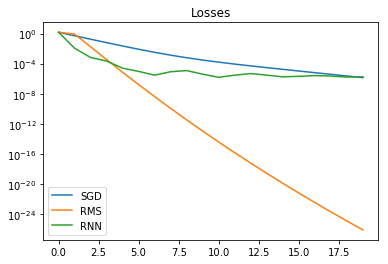

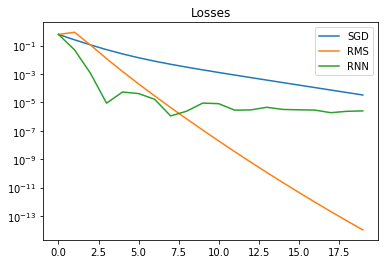

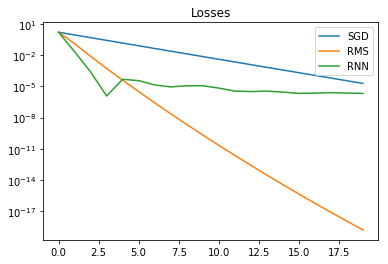

In [16]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

In [17]:
def rolling_log_average(array, L):
  """Rolling average of the log of the array over a length of L"""
  # Since the loss decrease in logarithm scale, we will apply this to track average results
  rolling_av = np.array([])
  for i in range(array.size):
    rolling_av = np.append(rolling_av, 10**(np.log10(array[:i+1][-L:] + 1e-38).mean()))
  return rolling_av

In [18]:
def draw_convergence(*args):
  """Draws the convergence of one or several meta optimizations
  transparent area is the raw results, the plain line is the 500 rolling 'log average'"""
  it = 0
  for f in args:
    it = max(eval(f).size, it)
  handles = []
  for f in args:
    flist = eval(f)
    flist_rolling = rolling_log_average(flist, 500)
    flist_size = flist.size
    if flist_size < it:
      flist = np.append(flist, [None]*(it-flist_size))
      flist_rolling = np.append(flist_rolling, [None]*(it-flist_size))
    c1, = plt.semilogy(range(it), flist, alpha=0.3)
    c2, = plt.semilogy(range(it), flist_rolling, color=c1.get_color(), label=f)
    handles = handles + [c2]
  plt.legend(handles=handles)
  plt.title('End result of the optimizer')
  plt.show()

As explained in the function docstring, the transparent area is the raw results, which allows a visualization of the scatter of results, while the plain line shows the 500 rolling "log average" to monitor overall progress.
I'll be using this function on the end result of the RNN. So here, it basically displays the last point of the previous graphs after each iteration of the "meta optimizer", which oscillates arround 1e-6 both at the end of both above and below graphs.

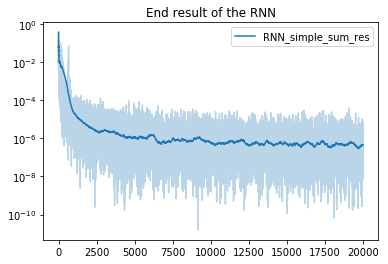

In [19]:
draw_convergence('RNN_simple_sum_res')

Now that we are all setup, we can go back to our RNN

### Let's beat RMSProp
Having a target is all well and good but how far off are we ?  
Let's run our 2 baseline (SGD and RMSProp) a 1000 times to find out

In [51]:
list_sgd_errors = np.array([])
list_rms_errors = np.array([])
for it in range(1000):
  sgd_errors, rms_errors = sess.run([sgd_losses, rms_losses])
  list_sgd_errors = np.append(list_sgd_errors, sgd_errors[-1])
  list_rms_errors = np.append(list_rms_errors, rms_errors[-1])

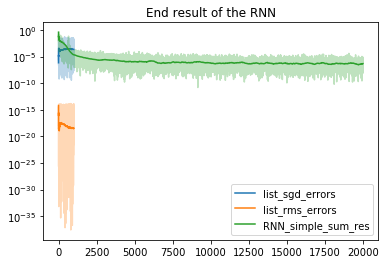

In [54]:
draw_convergence('list_sgd_errors', 'list_rms_errors', 'RNN_simple_sum_res')

Now that we have seen what the scatter looks like, we can replace the results by lists containing only the 'log' average :

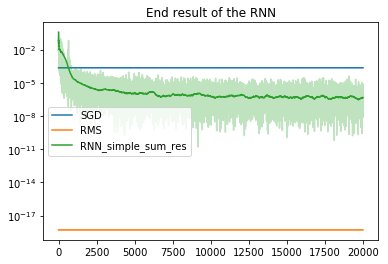

In [55]:
SGD = np.full(20000, rolling_log_average(list_sgd_errors, 1000)[-1])
RMS = np.full(20000, rolling_log_average(list_rms_errors, 1000)[-1])
draw_convergence('SGD', 'RMS', 'RNN_simple_sum_res')

Looks like we have our work cut out for us.  
Before we start meddling with the RNN inputs and outputs, there is a key parameter that we should try to fine tune :
#### The loss function
We are currently using as our loss function the sum of the errors across the 20 iterations. That's a good way to ensure that we both converge to 0 and get there as fast as possible, since the smaller the intermediate steps errors are, the quicker the optimizer is. However, given the problem we are trying to solve, the error at the end will be dwarfed by those from the first iterations, and their corresponding gradients will have the same behaviour.  
So, before we try to make an optimizer that gets to 0 quickly, we should try to find one that actually finds the 0 (if that's possible in 20 steps ...), or as said in the title, one that can beat RMSProp. To do that, let's focus only on the last error.

In [20]:
rnn_losses = learn(g_rnn)
end_losses = rnn_losses[-1]
# Target is now to minimize the result at the end of the 20 iterations
apply_update = optimize(end_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(20001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 2000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-2000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_simple_end_res = list_result

{'it': 0, 'optim_result': '2.07E-01', 'average_log_result': '-0.68'}
{'it': 2000, 'optim_result': '7.87E-04', 'average_log_result': '-3.14'}
{'it': 4000, 'optim_result': '7.15E-06', 'average_log_result': '-3.84'}
{'it': 6000, 'optim_result': '6.20E-05', 'average_log_result': '-4.27'}
{'it': 8000, 'optim_result': '3.48E-05', 'average_log_result': '-4.53'}
{'it': 10000, 'optim_result': '1.66E-05', 'average_log_result': '-5.21'}
{'it': 12000, 'optim_result': '1.83E-06', 'average_log_result': '-5.40'}
{'it': 14000, 'optim_result': '5.22E-08', 'average_log_result': '-5.87'}
{'it': 16000, 'optim_result': '3.67E-07', 'average_log_result': '-6.32'}
{'it': 18000, 'optim_result': '1.29E-06', 'average_log_result': '-6.62'}
{'it': 20000, 'optim_result': '2.65E-07', 'average_log_result': '-6.75'}


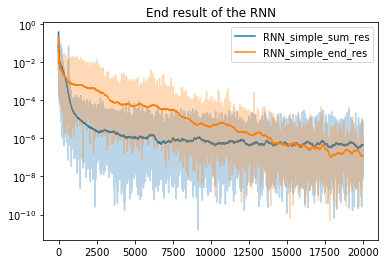

In [21]:
draw_convergence('RNN_simple_sum_res', 'RNN_simple_end_res')

As we are dealing with 2 levels of iterations, we need a naming convention to distinguish them. So let's call the "base" iterations the ones performed by the RNN being optimized or the benchmarks defined at the beginning, and "meta" iterations the ones performed by tensorflow optimizer (here we are using Adam, cf. optimize() function definition) to optimize the result of the "base" iterations of the RNN.

Regarding the effect of minimizing the end result rather than the sum of errors along the 20 "base" iterations, we can make 2 observations :
- We get about 1 order of magnitude improvement on the end result of the RNN after 20,000 "meta" iterations, which is not huge considering it is 1 out of 6 orders of magnitude overall
- The "meta" optimization is slower initially but does not look to be slowing doswn after the 20,000 it, so let's give it another 30,000 it

In [22]:
it = 20000
for _ in range(30000):
  it += 1
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_simple_end_res = list_result

{'it': 25000, 'optim_result': '2.24E-08', 'average_log_result': '-7.42'}
{'it': 30000, 'optim_result': '8.78E-08', 'average_log_result': '-7.56'}
{'it': 35000, 'optim_result': '8.41E-09', 'average_log_result': '-7.89'}
{'it': 40000, 'optim_result': '3.69E-08', 'average_log_result': '-7.69'}
{'it': 45000, 'optim_result': '2.41E-08', 'average_log_result': '-7.98'}
{'it': 50000, 'optim_result': '5.73E-09', 'average_log_result': '-8.12'}


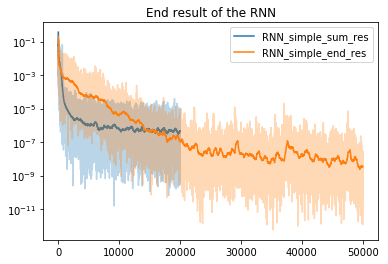

In [23]:
draw_convergence('RMS', 'RNN_simple_sum_res', 'RNN_simple_end_res')

Conclusions : the optimization seems to settle around 1e-8, which is a bit more significant in terms of improvement.  
The shape of "base" convergence of the 2 RNNs are also different with the first (displayed earlier) outperforming RMSProp in the first few iterations, then flattening out, while the second (displayed below) is more consistant across the 20 iterations. This illustrates the fact that using the sum of errors as the loss function focuses the optimization on the first few steps.

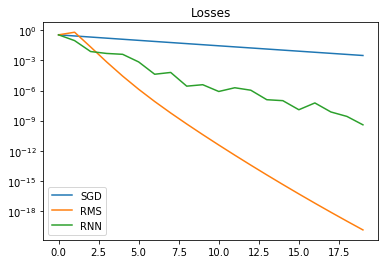

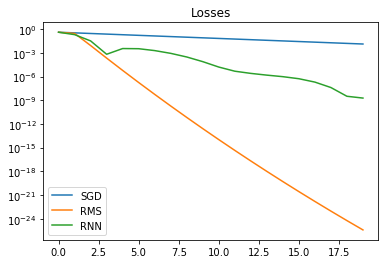

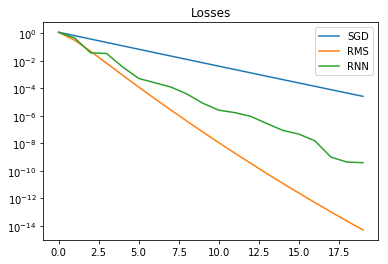

In [24]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

Before switching our focus to the RNN and how it processes the gradients, there is something else we could try with the loss function:

#### The loss function - using log scale
One problem with our current loss function is that, in order to beat RMSProp, we have to go from loss of around 1 to around 1E-15, and that's a problem when the inputs scale doesn't follow the same scale change. Even for optimizer equiped to deal with such vanishing gradients (like adam or RMSProp), the small scale can generate some accuracy problems.  
Tkanksfully, using the log of the error as our loss function adresses this problem. Let's see if it also brings some improvement to the RNN results 

In [25]:
rnn_losses = learn(g_rnn)
log_loss = tf.log(rnn_losses[-1]) # log added to the optimization target
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_simple_end_log_res = list_result

{'it': 0, 'optim_result': '3.30E-01', 'average_log_result': '-0.48'}
{'it': 5000, 'optim_result': '1.19E-05', 'average_log_result': '-3.81'}
{'it': 10000, 'optim_result': '8.13E-07', 'average_log_result': '-5.85'}
{'it': 15000, 'optim_result': '2.66E-09', 'average_log_result': '-6.91'}
{'it': 20000, 'optim_result': '3.50E-07', 'average_log_result': '-7.30'}
{'it': 25000, 'optim_result': '1.75E-09', 'average_log_result': '-7.45'}
{'it': 30000, 'optim_result': '4.53E-08', 'average_log_result': '-7.65'}
{'it': 35000, 'optim_result': '8.56E-10', 'average_log_result': '-7.77'}
{'it': 40000, 'optim_result': '1.01E-07', 'average_log_result': '-7.78'}
{'it': 45000, 'optim_result': '1.11E-08', 'average_log_result': '-7.82'}
{'it': 50000, 'optim_result': '1.05E-08', 'average_log_result': '-7.97'}


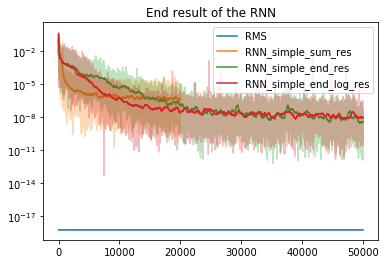

In [57]:
RMS = np.full(50000, rolling_log_average(list_rms_errors, 1000)[-1])
draw_convergence('RMS', 'RNN_simple_sum_res', 'RNN_simple_end_res', 'RNN_simple_end_log_res')

The answer is : apparently not ... there is a slightly better convergence rate but the end result is the same.  
This was either a terrible idea (and I sure have a lot of those :) or there is something else preventing the RNN from improving further. So let's put aside this idea for now, and see if we can improve how the RNN is set up.


#### The RNN inputs - log scale
Let's go back to the problem mentioned at the end of the first section: the changing scale of the inputs. As explained before, having inputs to RNN going from 1 to 1E-15 is not ideal (there are probably a few reasons for that, but one of them is that the bias and the activation functions in the RNN would need to follow the same scale change for the RNN to keep the same behaviour).  
One way to deal with that, as mentioned earlier, is to use the log of the gradient instead of directly the gradient. This has the advantage of making the output less sensitive to scale changes. For example having gradients go from 100 to 1 will be interpreted similarly by the RNN as a change from 1 to 0.01. Problem is that, with the last value we get into negative values and we need to keep a way to distinguish between positive and negative gradients. To deal with that, we add another operation that rescale, this time linearly, the log(|gardient|) from [min_log_gradient - 0] to [0 - 1] and then applies the sign of the gradient to the result. The result is a casting operation from [exp(min_log_gradient), 1] to [0, 1] and from [-1, -exp(min_log_gradient)] to [-1, 0].  
As you may have noticed I have introduced the min_log_gradient parameter because, since we are doing computer science, we need to stop somwhere. I've started with an arbitrary value of -15, so that gradients between exp(-15) and 1 are casted to values between 0 and 1, but we will investigate that further later on.

A few remarks :  
I had a look at the preprocessing proposed in Deepmind's paper, and I noticed 2 differences. They have second formula to deal with gradients smaller than exp(min_log_gradient). I didn't bother with that because I'm not sure the RNN I'm using would be able to deal with two different preprocessing regime anyway (at least not without increasing the depth of the network to make it "smarter").  
They also seem to rescale the log(gradient) differently : I'm probably missing something here, but it looks like 10 and -0.1 would result in the same input for the RNN with the proposed approach. So, if someone figures it out, I'm interested.  
That said, we already know their approach gives a huge performance boost compared to the most common optimizers on a variety of problems, so I'm pretty sure there are good reasons to do things this way

In [27]:
def g_rnn_log15(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-15), 1] to [0, 1] and [-1, -exp(-15)] to [-1, 0]
  min_log_gradient = -15 
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient-5)) # residual added to avoid log(0)
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-15), 1]  and [-1, 0] to [-1, -exp(-15)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log15)
end_losses = rnn_losses[-1]
apply_update = optimize(end_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_log15_end_res = list_result

{'it': 0, 'optim_result': '7.68E-01', 'average_log_result': '-0.11'}
{'it': 5000, 'optim_result': '4.87E-03', 'average_log_result': '-1.90'}
{'it': 10000, 'optim_result': '4.60E-03', 'average_log_result': '-2.73'}
{'it': 15000, 'optim_result': '9.02E-06', 'average_log_result': '-4.06'}
{'it': 20000, 'optim_result': '9.70E-05', 'average_log_result': '-4.77'}
{'it': 25000, 'optim_result': '9.97E-08', 'average_log_result': '-6.04'}
{'it': 30000, 'optim_result': '1.75E-05', 'average_log_result': '-7.37'}
{'it': 35000, 'optim_result': '2.14E-05', 'average_log_result': '-6.42'}
{'it': 40000, 'optim_result': '1.45E-07', 'average_log_result': '-6.63'}
{'it': 45000, 'optim_result': '2.11E-07', 'average_log_result': '-7.27'}
{'it': 50000, 'optim_result': '1.36E-07', 'average_log_result': '-7.27'}


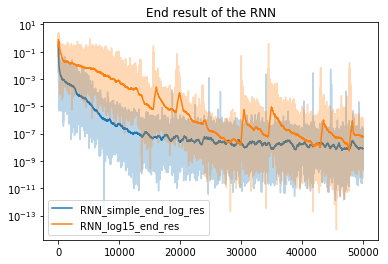

In [28]:
draw_convergence('RNN_simple_end_res', 'RNN_log15_end_res')

Now we do get briefly below the results of the initial RNN set-up, but the convergence is not stable.

Maybe it's time to revisit this loss function, and see if those vanishing gradients are the problem here. To do that, let's use the loss function defined in the section "The loss function - using log scale"

In [30]:
rnn_losses = learn(g_rnn_log15)
log_loss = tf.log(rnn_losses[-1]) # New target function
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_log15_end_log_res = list_result

{'it': 0, 'optim_result': '1.15E-01', 'average_log_result': '-0.94'}
{'it': 5000, 'optim_result': '2.51E-03', 'average_log_result': '-1.81'}
{'it': 10000, 'optim_result': '1.46E-04', 'average_log_result': '-2.46'}
{'it': 15000, 'optim_result': '1.39E-13', 'average_log_result': '-7.01'}
{'it': 20000, 'optim_result': '2.01E-13', 'average_log_result': '-11.40'}
{'it': 25000, 'optim_result': '5.39E-13', 'average_log_result': '-12.04'}
{'it': 30000, 'optim_result': '8.85E-12', 'average_log_result': '-12.22'}
{'it': 35000, 'optim_result': '2.12E-13', 'average_log_result': '-12.32'}
{'it': 40000, 'optim_result': '5.89E-13', 'average_log_result': '-12.35'}
{'it': 45000, 'optim_result': '2.89E-13', 'average_log_result': '-12.31'}
{'it': 50000, 'optim_result': '3.00E-13', 'average_log_result': '-12.33'}


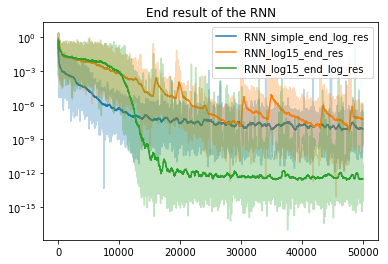

In [31]:
draw_convergence('RMS', 'RNN_simple_end_log_res', 'RNN_log15_end_res', 'RNN_log15_end_log_res')

Now we are getting somwhere! Let's look how the "base" convergence looks like :

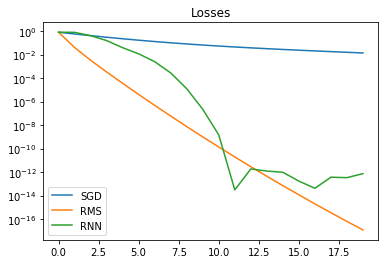

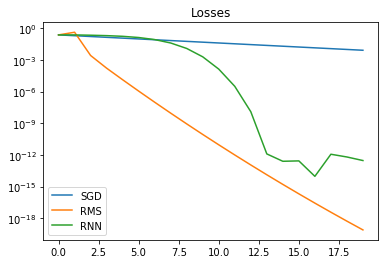

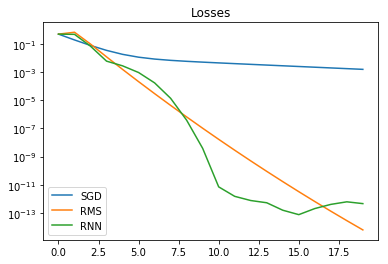

In [32]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

So, still not as good as RMSProp, but we are getting there !  
I said earlier that the min_log_gradient set at -15 was arbitrary. In order to increase the range of gradients across which our rescaling of gradients works, we can reduce this value :

In [43]:
def g_rnn_log30(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-30), 1] to [0, 1] and [-1, -exp(-30)] to [-1, 0]
  min_log_gradient = -30 
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient-5))
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-30), 1]  and [-1, 0] to [-1, -exp(-30)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log30)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_log30_end_log_res = list_result

{'it': 0, 'optim_result': '1.04E+00', 'average_log_result': '0.02'}
{'it': 5000, 'optim_result': '2.26E-01', 'average_log_result': '-0.77'}
{'it': 10000, 'optim_result': '7.56E-03', 'average_log_result': '-2.25'}
{'it': 15000, 'optim_result': '2.33E-01', 'average_log_result': '-4.52'}
{'it': 20000, 'optim_result': '4.22E-24', 'average_log_result': '-5.20'}
{'it': 25000, 'optim_result': '1.71E-03', 'average_log_result': '-5.18'}
{'it': 30000, 'optim_result': '1.35E-07', 'average_log_result': '-5.47'}
{'it': 35000, 'optim_result': '7.16E-26', 'average_log_result': '-11.19'}
{'it': 40000, 'optim_result': '4.35E-10', 'average_log_result': '-17.25'}
{'it': 45000, 'optim_result': '5.71E-20', 'average_log_result': '-18.91'}
{'it': 50000, 'optim_result': '2.70E-26', 'average_log_result': '-20.12'}


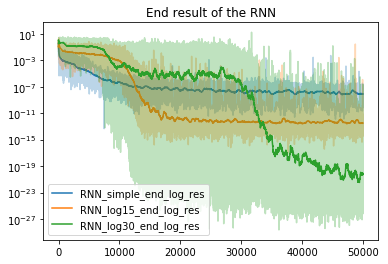

In [44]:
draw_convergence('RNN_simple_end_log_res', 'RNN_log15_end_log_res', 'RNN_log30_end_log_res')

Looks like we have another big improvement ... at the cost of a slower convergence rate.  
So let's add another 50,000 iterations to see where we end up :

In [45]:
it = 50000
for _ in range(50000):
  it += 1
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_log30_end_log_res = list_result

{'it': 55000, 'optim_result': '4.96E-25', 'average_log_result': '-21.18'}
{'it': 60000, 'optim_result': '2.30E-15', 'average_log_result': '-21.62'}
{'it': 65000, 'optim_result': '1.18E-25', 'average_log_result': '-22.00'}
{'it': 70000, 'optim_result': '4.21E-25', 'average_log_result': '-22.05'}
{'it': 75000, 'optim_result': '2.48E-20', 'average_log_result': '-22.51'}
{'it': 80000, 'optim_result': '3.53E-26', 'average_log_result': '-23.00'}
{'it': 85000, 'optim_result': '1.99E-20', 'average_log_result': '-22.79'}
{'it': 90000, 'optim_result': '5.43E-26', 'average_log_result': '-23.13'}
{'it': 95000, 'optim_result': '5.27E-26', 'average_log_result': '-22.82'}
{'it': 100000, 'optim_result': '6.71E-27', 'average_log_result': '-23.20'}


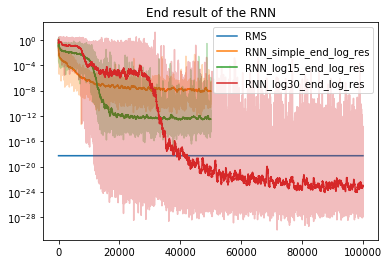

In [58]:
RMS = np.full(100000, rolling_log_average(list_rms_errors, 1000)[-1])
draw_convergence('RMS', 'RNN_simple_end_log_res', 'RNN_log15_end_log_res', 'RNN_log30_end_log_res')

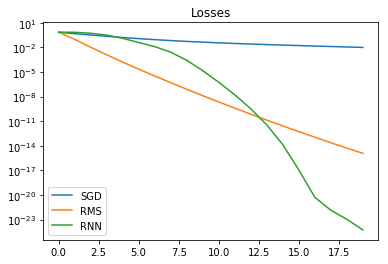

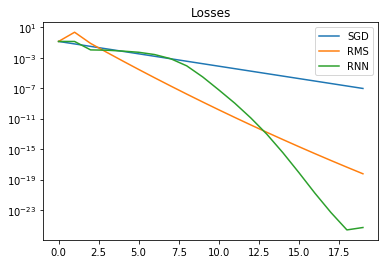

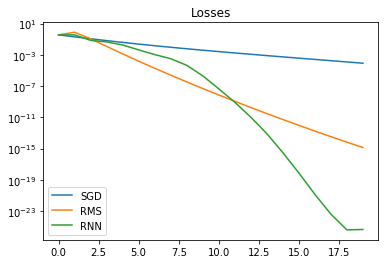

In [47]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

Looks like we can finally declare victory over RMSProp!

#### What's next
We seem to have gotten to a set-up which can outperform RMSProp, so the target is reached. But we still have quite a few open questions :  
I mentioned that I chose the `min_log_gradient` parameter kind of arbitrarily. This is obviously not satisfying from ... well, any point of views. I tried to go further than -30 but the convergence becomes either too slow or doesn't even start, so we should try to understand this better and find a workaround.  
I also mentionned, at the end of the first section, that there might be other ways to preprocess the gradients than just log rescaling, so we can also explore that further ... in the next episode of The Quest for the Ultimate Optimizer